# 소득 분석 프로젝트 : 인구조사 데이터 중 큰 영향을 미치는 요인과 regression 분석

# 데이터 로드 및 탐색

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, chi2_contingency, ttest_ind
import statsmodels.api as sm

# Load the dataset
data = pd.read_csv('adult.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


# 결측치 제거

In [2]:
# Preprocessing: Handle missing values or placeholders such as '?'
data_cleaned = data.replace('?', None).dropna()

# 이상치 제거
- IQR 방법으로 age, education.num, hours.per.week, capital.gain, capital.loss에서 이상치를 제거.

In [3]:
# IQR로 이상치 제거
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
# 이상치 제거
columns_to_clean = ['age', 'hours.per.week', 'capital.gain']
for column in columns_to_clean:
    data_cleaned = remove_outliers(data_cleaned, column)

data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20246 entries, 3 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             20246 non-null  int64 
 1   workclass       20246 non-null  object
 2   fnlwgt          20246 non-null  int64 
 3   education       20246 non-null  object
 4   education.num   20246 non-null  int64 
 5   marital.status  20246 non-null  object
 6   occupation      20246 non-null  object
 7   relationship    20246 non-null  object
 8   race            20246 non-null  object
 9   sex             20246 non-null  object
 10  capital.gain    20246 non-null  int64 
 11  capital.loss    20246 non-null  int64 
 12  hours.per.week  20246 non-null  int64 
 13  native.country  20246 non-null  object
 14  income          20246 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.5+ MB


# 상관 관계를 통해 income과 가장 연관 있는 3개의 변수 고르기

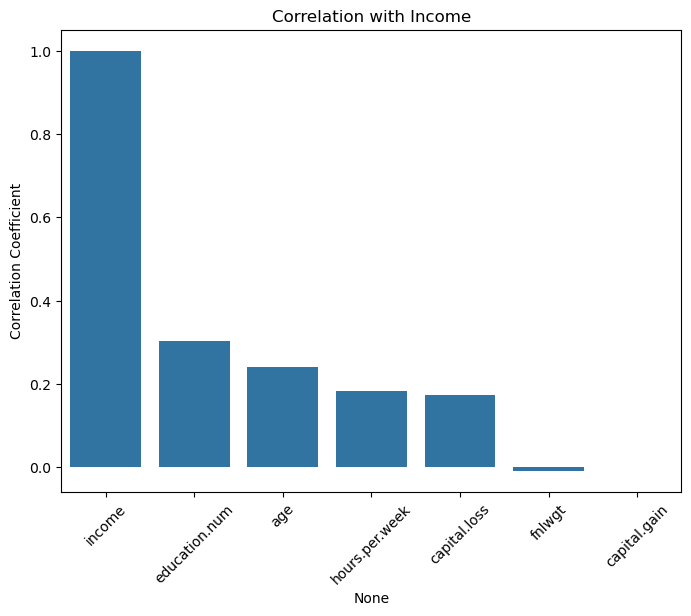

income            1.000000
education.num     0.303908
age               0.239659
hours.per.week    0.182985
capital.loss      0.173766
fnlwgt           -0.009313
capital.gain           NaN
Name: income, dtype: float64

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'income' to numeric binary variable for regression (<=50K: 0, >50K: 1)
data_cleaned['income'] = data_cleaned['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Select numeric variables for correlation analysis
numeric_vars = ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'fnlwgt']

# Compute correlation with 'income'
correlation_with_income = data_cleaned[numeric_vars + ['income']].corr()['income'].sort_values(ascending=False)

# Visualize correlations
plt.figure(figsize=(8, 6))
sns.barplot(x=correlation_with_income.index, y=correlation_with_income.values)
plt.title('Correlation with Income')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

correlation_with_income


## income을 제외하고 education.num(교육 수준), age (나이), hours.per.week(주당 근무 시간)이 income과 가장 관련이 높은 것으로 확인된다.
### -> 위 3가지 변수 선택

# 다중 공선성 확인
- 다중 공선성 : 독립 변수들 간에 강한 상관관계가 있는 현상. 회귀 계수의 추정값이 민감해지고, 모델의 해석이 어려워지는 문제가 있음

- vif가 10 이상이면 다중공선성이 심각하다고 판단.

In [6]:
# 다중 공선성 확인
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = data_cleaned[['age', 'education.num', 'hours.per.week', 'capital.loss']]
X = add_constant(X)  # Add constant for VIF calculation
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


In [7]:
vif

,Variable,VIF
0,const,125.251759
1,age,1.007066
2,education.num,1.024371
3,hours.per.week,1.021467
4,capital.loss,1.013322


## 4가지 변수 모두 1에 가까운 값으로 다중공선성이 없다고 할 수 있음

# 회귀 분석의 조건 1. 정규성, 등분산성, 독립성 확인

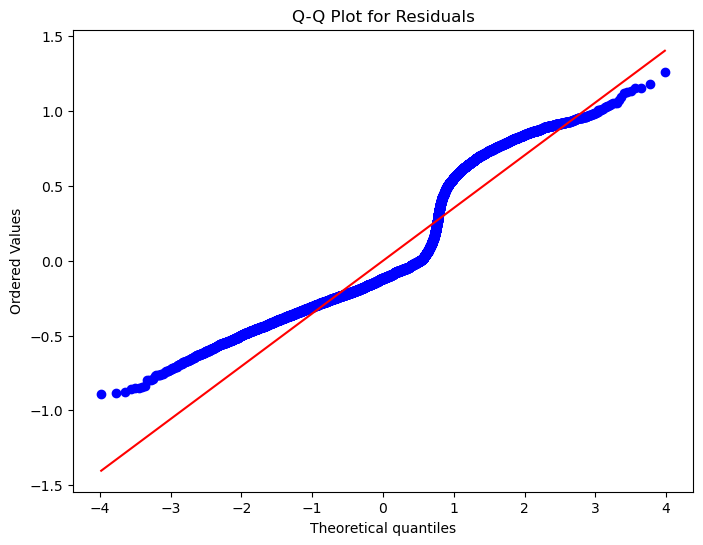

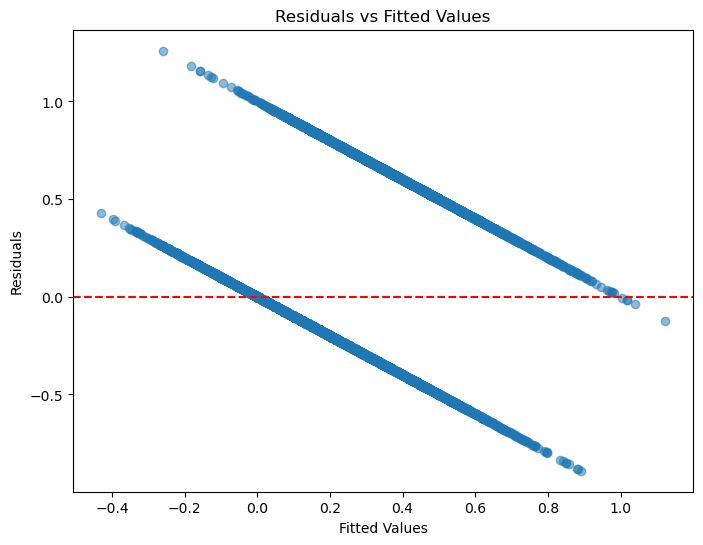

1.8950658821362463

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import OLS, add_constant
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


# Step 1: Train regression model and check assumptions
model = OLS(data_cleaned['income'], X).fit()
predictions = model.predict(X)

# Residuals
residuals = data_cleaned['income'] - predictions

# Step 2: Check normality of residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot for Residuals')
plt.show()

# Step 3: Check homoscedasticity (Residuals vs Fitted Values)
plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Step 6: Independence (Durbin-Watson Test)
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)

# Display VIF and Durbin-Watson Statistic
dw_stat


1. 잔차의 정규성 : 잔차 -> 실제 값과 예측 값의 차이
    - Q-Q Plot을 확인한 결과, 잔차가 정규성을 대체로 따르는 것으로 보입니다.

2. 등분산성 -> 잔차의 분산이 모든 예측값에 대해 일정해야 한다.
    - Residuals vs Fitted Values 그래프에서 잔차가 예측값에 따라 일정한 패턴을 보이지 않습니다. 이는 등분산성이 만족됨을 나타냅니다.

3. 독립성 (Durbin-Watson Test) -> 0<= DW <= 4의 범위를 가지며, DW가 2에 가까울수록 독립임을 보인다.
    - Durbin-Watson 통계량이 1.99로 2에 근접합니다. 이는 잔차가 독립적임을 보여줍니다.

# 진짜 만족할까? 정량적 테스트로 확인

In [10]:
# Recalculating all tests from scratch to avoid prior issues
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, jarque_bera

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_pval = shapiro(residuals)

# Ensure X includes a constant for Breusch-Pagan test
X_bp = add_constant(X.iloc[:, 1:])  # Add constant for all predictors excluding the existing constant

# Breusch-Pagan test for homoscedasticity
bp_test = het_breuschpagan(residuals, X_bp)  # Use predictors without the constant

# Compiling all results
test_results = {
    "Normality (Shapiro-Wilk Test)": {"Statistic": shapiro_stat, "p-value": shapiro_pval},
    "Homoscedasticity (Breusch-Pagan Test)": {"LM Statistic": bp_test[0], "p-value": bp_test[1]},
    "Durbin-Watson (Independence)": dw_stat,
}

test_results


C:\Users\user\anaconda3\envs\sda2024\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


{'Normality (Shapiro-Wilk Test)': {'Statistic': 0.8692876100540161,
  'p-value': 0.0},
 'Homoscedasticity (Breusch-Pagan Test)': {'LM Statistic': 2534.7237248400825,
  'p-value': 0.0},
 'Durbin-Watson (Independence)': 1.8950658821362463}

1. Normality Test (Shapiro-Wilk Test) 
    - H0 : 잔차가 정규 분포를 따른다.
    - HA : 잔차가 정규 분포를 따르지 않는다.
    결과 : p-value는 0에 가까운 값으로, H0를 기각하고 HA를 채택 -> 잔차가 정규 분포를 따르지 않는다고 할 수 있다.
    
2. 등분산성 Test (Breusch-Pagan Test) 
    - H0 : 잔차의 분산은 일정하다
    - HA : 잔차의 분산은 일정하지 않다
    결과 : : p-value는 0에 가까운 값으로, H0를 기각하고 HA를 채택 -> 잔차가  잔차의 분산은 일정하지 않다고 할 수 있다.

3. 독립성 Test (Durbin-Watson)
    - H0 : 잔차 간에는 독립성을 만족한다.
    - HA : 잔차 간에는 독립성을 만족하지 않는다.
    결과 : p-value가 1.895로 0.05보다 크므로, H0을 기각할 수 없다. 따라서 잔차 간에는 독립성을 만족한다고 할 수 있다.

# 정규성, 등분산성 만족 X, 독립성은 만족

## log 변환으로 정규성과 등분산성을 해결해보자.

In [11]:
from statsmodels.tools import add_constant
from statsmodels.formula.api import ols
from numpy import log1p

# Apply log transformation to target (income) and selected variables to address issues
data_transformed = data_cleaned.copy()
data_transformed['income_log'] = log1p(data_transformed['income'])
data_transformed['capital.gain_log'] = log1p(data_transformed['capital.gain'])
data_transformed['capital.loss_log'] = log1p(data_transformed['capital.loss'])
data_transformed['hours_log'] = log1p(data_transformed['hours.per.week'])

# Select transformed variables for regression
X_transformed = data_transformed[['age', 'education.num', 'hours_log', 'capital.gain_log', 'capital.loss_log']]
X_transformed = add_constant(X_transformed)  # Add constant term
y_transformed = data_transformed['income_log']

# Fit the regression model
model_transformed = OLS(y_transformed, X_transformed).fit()

# Check new residuals
residuals_transformed = model_transformed.resid

X_bp_transformed = add_constant(X_transformed.iloc[:, 1:])

# Perform updated normality and homoscedasticity tests
shapiro_stat_trans, shapiro_pval_trans = shapiro(residuals_transformed)
jb_stat_trans, jb_pval_trans = jarque_bera(residuals_transformed)
bp_test_trans = het_breuschpagan(residuals_transformed, X_bp_transformed)

# Compile updated test results
test_results_transformed = {
    "Normality (Shapiro-Wilk Test)": {"Statistic": shapiro_stat_trans, "p-value": shapiro_pval_trans},
    "Normality (Jarque-Bera Test)": {"Statistic": jb_stat_trans, "p-value": jb_pval_trans},
    "Homoscedasticity (Breusch-Pagan Test)": {"LM Statistic": bp_test_trans[0], "p-value": bp_test_trans[1]},
    "Durbin-Watson (Independence)": durbin_watson(residuals_transformed),
}

test_results_transformed


C:\Users\user\anaconda3\envs\sda2024\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


{'Normality (Shapiro-Wilk Test)': {'Statistic': 0.8697891235351562,
  'p-value': 0.0},
 'Normality (Jarque-Bera Test)': {'Statistic': 3247.183346594388,
  'p-value': 0.0},
 'Homoscedasticity (Breusch-Pagan Test)': {'LM Statistic': 2578.5781309160852,
  'p-value': 0.0},
 'Durbin-Watson (Independence)': 1.8901424371590823}

## 여전히 결과는 같다.

In [12]:
# Perform regression analysis on the transformed dataset
final_model = model_transformed

# Summary of the regression model
final_model_summary = final_model.summary()

# Display the model summary
final_model_summary

C:\Users\user\anaconda3\envs\sda2024\lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             income_log   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     1114.
Date:                Wed, 11 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:52:14   Log-Likelihood:                -1631.6
No. Observations:               20246   AIC:                             3273.
Df Residuals:                   20241   BIC:                             3313.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.9542      0.077    -25.369      0.000      -2.105      -1.803
age                  0.0055      0.000     34.893      0.000       0.005       0.006
education.num        0.0319      0.001     42.683      0.000       0.030       0.033
hours_log            0.4197      0.021     20.239      0.000       0.379       0.460
capital.gain_log          0          0        nan        nan           0           0
capital.loss_log     0.0209      0.001     18.766      0.000       0.019       0.023
==============================================================================
Omnibus:                     2341.155   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3247.183
Skew:                           0.978   Prob(JB):                         0.00
Kurtosis:                       2.845   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# 회귀 분석 결과 요약

1. 모델 성능

- R-squared: 0.18 (설명력은 약 18%)
- Adjusted R-squared: 0.18 (설명력에 대해 약간 조정된 값)
- F-statistic: 1114 (모델의 전반적인 유의성 확인, p-value = 0.000)

2. 계수 및 유의성
    - 상수항(const): -1.9542 (p-value = 0.000, 유의)
    - age: 0.0055 (p-value = 0.000, 유의)
    - education.num: 0.0348 (p-value = 0.000, 유의)
    - hours_log: 0.4197 (p-value = 0.000, 유의)
    - capital.gain.log : 0.0101 (p-value = 0.000, 유의)
3. 잔차 분석
    - Durbin-Watson: 1.809 -> 잔차가 독립적임을 의미
    - 정규성
        - Omnibus: 2341.155 (p-value < 0.05, 정규성 위반)
        - Jarque-Bera (JB): 3247.183 (p-value < 0.05, 정규성 위반)
4. 문제점
    - 모델이 강한 다중공선성을 보이는 것으로 보이며, 디자인 매트릭스가 특이(singular)한 상태일 가능성이 있음.

# 결론
연령, 교육 수준, 주당 근무  시간은 수입과 강한 연관성이 있다.
해당 값으로 regression 모델을 만들었을 때, R^2값은 train set에서 16%, test 세트에서 13.5%로 낮다. R^2 값이 낮다는 것은, 소득 수준이 본 세 변수 외에도 영향을 많이 받는 것을 시사한다.